https://dilithjay.com/blog/custom-image-classifier-with-pytorch

In [54]:
import torchvision
from torchvision.datasets import ImageFolder
import torch
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image, ImageReadMode

EPOCHS = 10
SIZE = 224
CLASSES = 3


In [55]:

#train_dataset = torchvision.datasets.ImageFolder(root='./images/train', transform=transform)
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [56]:
import glob
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['jpg']:
        #for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            #class_set.add(os.path.dirname(path))
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]
        
        return self.transform(img), torch.tensor(label)
    

In [57]:
dataset = CustomDataset('.\\images\\train', transform)
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

val_set.transform = test_set.transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE))
])


In [58]:
from torch.utils.data import Dataset
dataloaders = {
    "train": DataLoader(train_set, batch_size=16, shuffle=True),
    "test": DataLoader(test_set, batch_size=16, shuffle=False),
    "val": DataLoader(val_set, batch_size=16, shuffle=False)
}

### Multi class model

In [59]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.linear1 = torch.nn.Linear(512, 256)
        self.activation = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(0.1)
        self.linear2 = torch.nn.Linear(256, CLASSES)
        self.dropout2 = torch.nn.Dropout(0.1)
        #self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = self.softmax(x)
        return x


### Binary model

class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.linear1 = torch.nn.Linear(128, 256)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(256, 1)
        self.softmax = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


In [60]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}



In [62]:
# Initialize early stopping parameters
best_val_loss = float('inf')  # Start with a very high value
patience = 5  # Number of epochs to wait for improvement
patience_counter = 0  # Counter for patience

for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(dataloaders['train'])
  
  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels in dataloaders[phase]:
      
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=3)

        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1
  
    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)
    
    # Early stopping logic based on validation loss
    if phase == 'val':
      if ep_loss < best_val_loss:
        best_val_loss = ep_loss  # Update best loss
        patience_counter = 0  # Reset patience counter
        print("Validation loss improved. Saving model...")
        # Optionally save the model checkpoint here
        torch.save(model.state_dict(), 'best_model.pth')
      else:
        patience_counter += 1
        print(f'No improvement in validation loss. Patience counter: {patience_counter}/{patience}')
    # Check for early stopping
  if patience_counter >= patience:
    print("Early stopping triggered. Stopping training.")
    break  # Exit the training loop

  model.load_state_dict(torch.load('best_model.pth', weights_only=True))


-------- train --------
Loss: 0.9513111114501953, Accuracy: 0.6369047619047619

-------- val --------
Loss: 0.8542696038881937, Accuracy: 0.652777781089147

Validation loss improved. Saving model...
-------- train --------
Loss: 0.6756326187224615, Accuracy: 0.8660714285714286

-------- val --------
Loss: 0.6591938734054565, Accuracy: 0.8217592636744181

Validation loss improved. Saving model...
-------- train --------
Loss: 0.5259627288296109, Accuracy: 0.8809523809523809

-------- val --------
Loss: 0.5270716746648153, Accuracy: 0.8634259303410848

Validation loss improved. Saving model...
-------- train --------
Loss: 0.4351024556727636, Accuracy: 0.9047619047619048

-------- val --------
Loss: 0.47364704807599384, Accuracy: 0.8217592636744181

Validation loss improved. Saving model...
-------- train --------
Loss: 0.3399477352698644, Accuracy: 0.9285714285714286

-------- val --------
Loss: 0.4854164620240529, Accuracy: 0.7893518606821696

No improvement in validation loss. Patienc

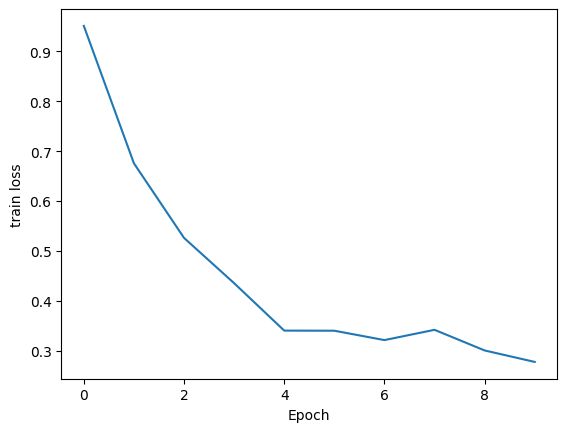

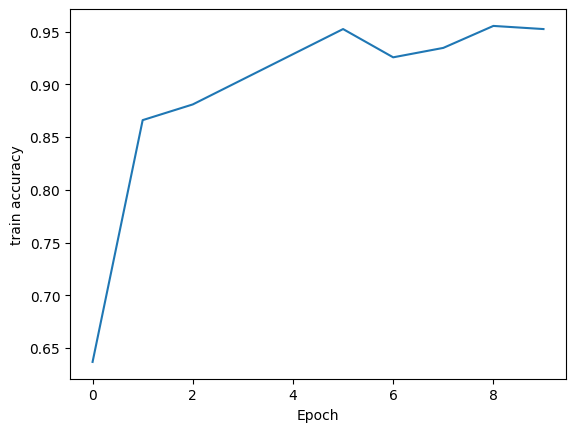

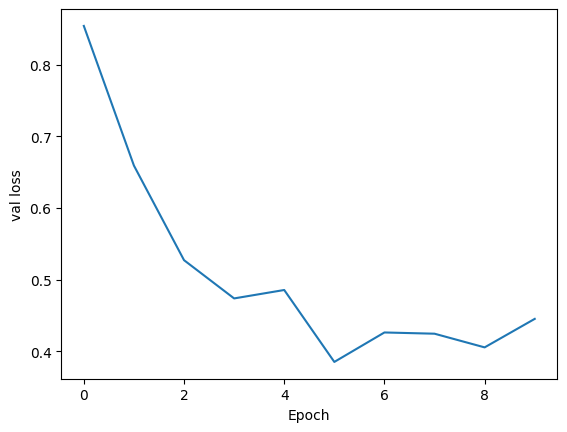

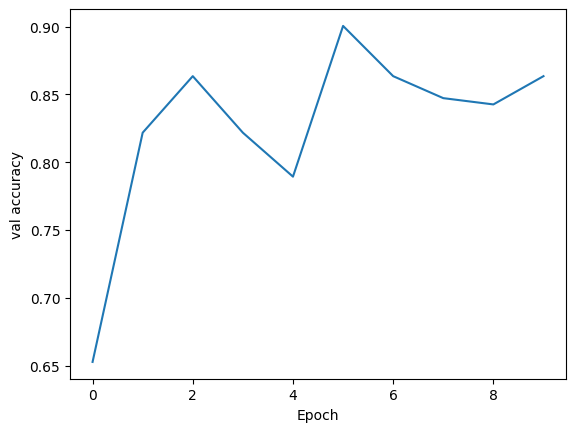

100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Test Loss: 0.2532976567745209, Test Accuracy: 0.9791666865348816


In [63]:
import matplotlib.pyplot as plt
from tqdm import tqdm

for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")


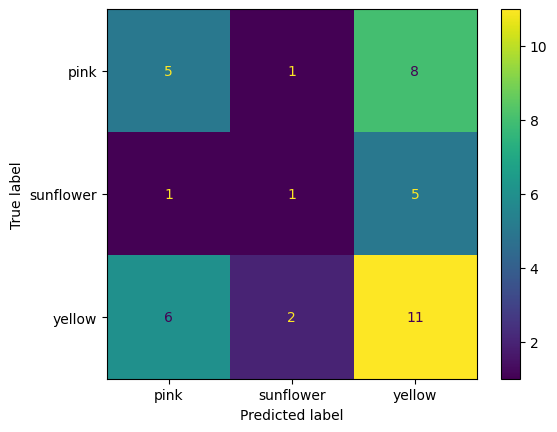

,Precision,Recall
pink,0.416667,0.357143
sunflower,0.250000,0.142857
yellow,0.458333,0.578947


In [41]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

class_labels = sorted(dataset.class_lbl.keys())

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]
stats

